# Ch 08. ATTENTION
attention is powerful and beautiful tech!

## 8.1 structure of attention
attention mechanism allows machine to give 'attention' on neccessary information only.  
also it solves problem that seq2seq had.  

### 8.1.1. seq2seq's problem 
output of Encoder is fixed size vector.  
this is quite a problem. because both one sentence and million sentence has to take same space.  

### 8.1.2 Improving Encoder
we want to manipulate the size of Encodcer's output.  
we will use use every LSTM's hidden vectors.  
LSTM will (mostly) have information from directly given inputs.  
we can think hs(matrix from rows of LSTM's output).  
each row of hs has informations of inputs.  
  
ok, but how do we change Decoder?  
theres alot to improve.  

### 8.1.3 Decoder Improvement - 1
Encoder gets sentence, spits hs(matrix)  
Decoder gets hs, spits another sentence.  
seq2seq only uses last row of hs.  
  
we will put another vertical layer of caculation in Decoder.  
this layer havs two input. 1. hs, 2. LSTM's hidden vector.  
  
we want to find 'alignment' between words. (cat <-> gato, man <-> hombre )  
when Decoder spits 'i', we want Decoder to find vector that has information of '나'.  
  
but here comes another problem, selecting cannot be derive. therefore, cannot be backpropagated.  
solution: we choose EVERY vector, and we caculate contributions. we call this vector 'a'.  
we will get weighted sum between hs and a, we will get context vector 'c'.

In [2]:
import numpy as np

T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5, 1).repeat(4, axis = 1)
print(ar.shape)

t = hs * ar
print(ar.shape)

c = np.sum(t, axis=0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


In [3]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis = 2)

t = hs * ar
print(t.shape)

c = np.sum(t, axis=1)
print(c.shape)

(10, 5, 4)
(10, 4)


backpropagation of repeat is sum. and vice versa. 

In [4]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis = 2)
        t = hs * ar
        
        c = np.sum(t, axis = 1)
        
        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1) #backprop of sum
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2) #backprop of repeat
        
        return dhs, da

## 8.1.4 Decoder Improvement - 2
vector a tells importance of each words. how do we get vector a?  
in order to do so, we need to see how Decoder' LSTM returns hidden vector.  
Decoder's LSTM also returns vector h.  
we need to evaulate similarities between h and each row's from hs.  
we will use inner product.  
we get unnormalized vector s, we use Softmax to get vector a.

In [5]:
import sys
sys.path.append('..')
from common.layers import Softmax
import numpy as np

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis = 1)

t = hs * hr
print(t.shape)

s = np.sum(t, axis = 2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)
(10, 5)


we need 1.Repeat node, 2. element product node, 3. sum node 4.Softmax node.  
we made AttentionWeight class.  
check : ch08/attention_layer.py

In [6]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh



### 8.1.5 Decoder Improvement - 3
we made AttentionWeight, and WeightSum. now we combine two into one.  
check: ch08/attention_layer.py

In [7]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh


we collapse multiple LSTM and name them 'TimeAttention'

In [8]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec


## 8.2 seq2seq with Attention
we implement 3 classes. 1. AttentionEncoder, 2.AttentionDecoder, 3.AttentionSeq2Seq

### 8.2.1 Encoder
note we return all the hidden vector.

In [10]:

from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### 8.2.2 Decoder


In [11]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled


### 8.2.3 seq2seq implementation

In [12]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads


## 8.3 Evaluating Attention
we will test with date format transformation data.

### 8.3.1 date format tranformation problem
september 27, 1994 <-> 1994-09-27  
JUN 17, 2013 <-> 2013-06-17  
2/10/93 <-> 1993-02-10  
  
dataset is in dataset/date.txt

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 81 / 351 | 시간 23[s] | 손실 1.46
| 에폭 1 |  반복 21 / 351 | 시간 8[s] | 손실 3.09
| 에폭 1 |  반복 101 / 351 | 시간 31[s] | 손실 1.19
| 에폭 1 |  반복 41 / 351 | 시간 17[s] | 손실 1.90
| 에폭 1 |  반복 121 / 351 | 시간 40[s] | 손실 1.14
| 에폭 1 |  반복 61 / 351 | 시간 26[s] | 손실 1.72
| 에폭 1 |  반복 141 / 351 | 시간 48[s] | 손실 1.09
| 에폭 1 |  반복 81 / 351 | 시간 34[s] | 손실 1.46
| 에폭 1 |  반복 161 / 351 | 시간 57[s] | 손실 1.06
| 에폭 1 |  반복 101 / 351 | 시간 43[s] | 손실 1.19
| 에폭 1 |  반복 181 / 351 | 시간 65[s] | 손실 1.04
| 에폭 1 |  반복 121 / 351 | 시간 51[s] | 손실 1.14
| 에폭 1 |  반복 201 / 351 | 시간 73[s] | 손실 1.03
| 에폭 1 |  반복 141 / 351 | 시간 60[s] | 손실 1.09
| 에폭 1 |  반복 221 / 351 | 시간 81[s] | 손실 1.02
| 에폭 1 |  반복 161 / 351 | 시간 68[s] | 손실 1.06
| 에폭 1 |  반복 241 / 351 | 시간 90[s] | 손실 1.02
| 에폭 1 |  반복 181 / 351 | 시간 76[s] | 손실 1.04
| 에폭 1 |  반복 261 / 351 | 시간 98[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 106[s] | 손실 1.00
| 에폭 1 |  반복 201 / 351 | 시간 85[s] | 손실 1.03
| 에폭 1 |  반복 301 / 351 | 시간 114[s] | 손실 

c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


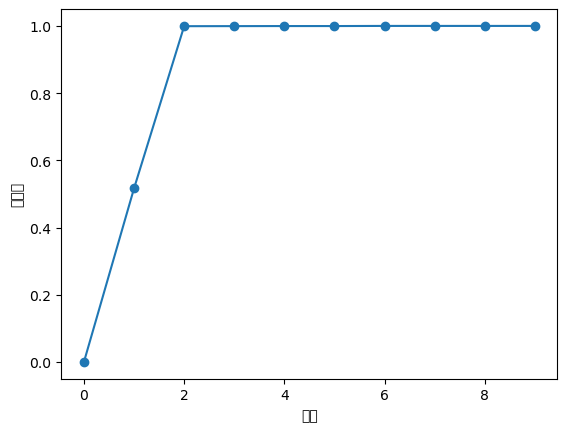

정확도 100.000%


c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\GAILAB\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


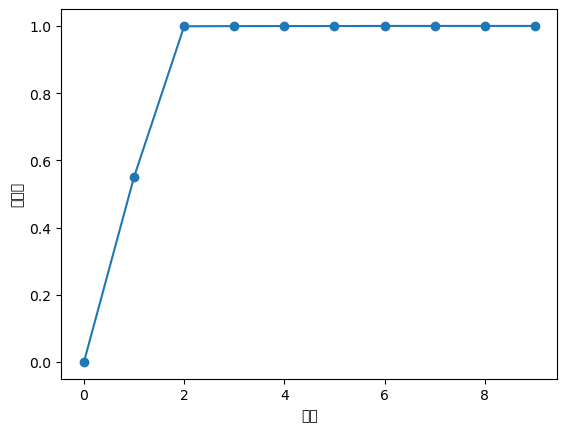

In [14]:
from ch08 import train

### 8.3.3 Visualizing Attention 
Attention layer has information of each weightsum, so its relatively easy.  
we can get 2D table between input seq and output seq.  
this way, human can see relationship between words.

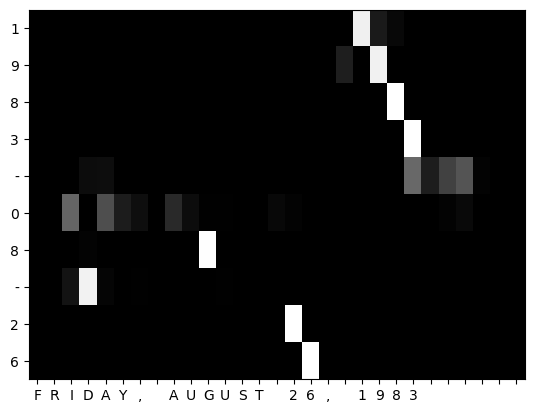

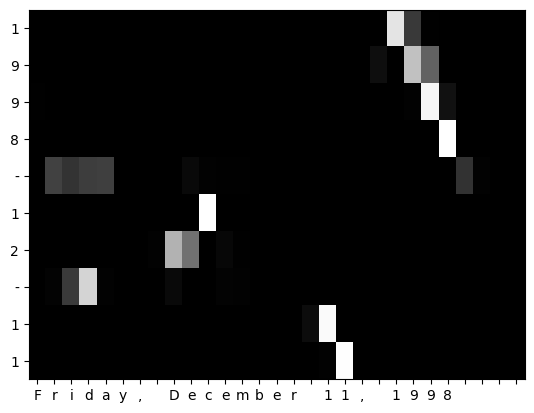

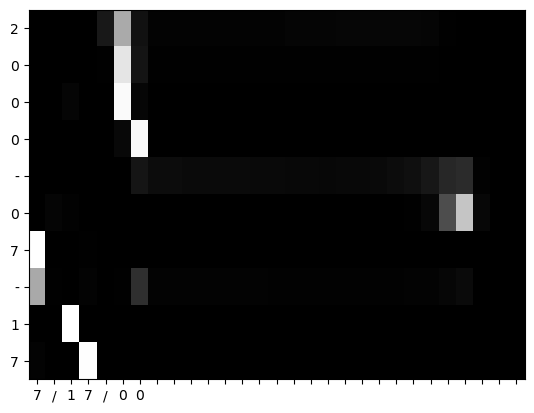

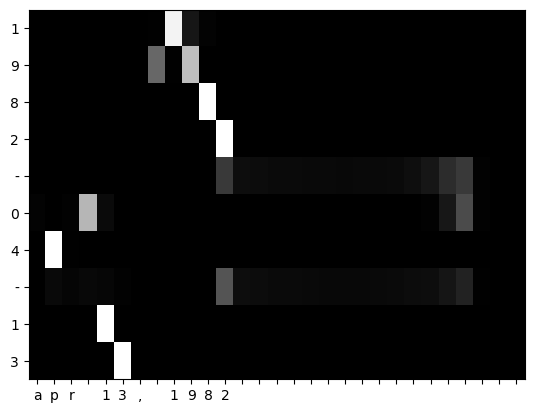

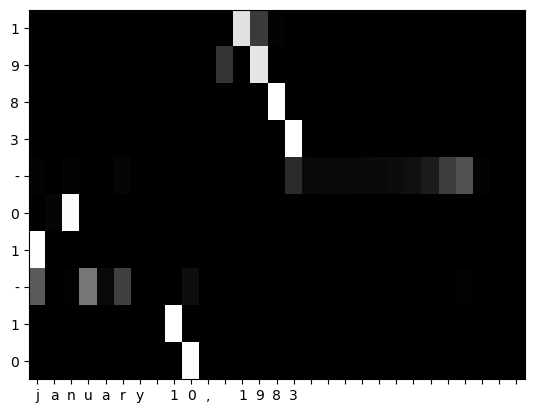

In [15]:
from ch08 import visualize_attention

## 8.4 leftover story of Attention

### 8.4.1 Bidirectional RNN
hs has information from LSTM.  
human read sentence left to right.  
we want to make words near target words relevant.  
therefore we use bidirectional LSTM.  
check : common/time_layers.py TimeBiLSTM

### 8.4.2 how to use Attention Layer
we insert attention layer between LSTM and Affine, but it doesnt have to be this way.  
there are many options.  
we can consider Attention layer's output is feeded into LSTM's input.  
which one is better? its hard problem. you have to use it for real data.

### 8.4.3 deepening seq2seq and skip connection.  
we can stack more LSTM.  
we can stack 3 LSTM in both Encoder and Decoder.  
skip connection(residual connection, short-cut) is used for deep seq2seq.  
its just ResNet idea. 

## 8.5 Application of Attention

### 8.5.1 Google Neural Machine Translation (GNMT) 


### 8.5.2 Transformer
RNN also has its limit. one of them is parallel processing.  
RNN is fundamentally sequential, and GPU is fundamentally parallel.  
people are developing RNN that does parallel computing, or not using RNN.  
  
one of solution is 'Transformer' from the 'Attention is all you need' paper.  
  
Transformer is consists of Attention, and it uses 'Self-Attention'  
it means finding relationship between words in one time-series data.  
Transformer does not use RNN. 

### 8.5.3 Neural Turing Machine(NTM)
paper and pen helps human to think. we can consider them as a storage device.  
what if Machine have such storage?  
(RNN remembers time-series data by internal parameter. but its still fixed space.)  
we can consider RNN like Encoder writes informations in memory, and Decoder reades memory.  
  
we can just use actual memory and let Encoder/Decoder have access to it.  
that is Neural Turing Machine.  
'Controller' unit gets information and writes on the memory, thus it has turing-machine like ability.  
  
what is really interesting is memory manipulation can be operation that can be derived(!).  
therefore, memory manipulating can be trained from data.  
  
NTM is very powerful. it can learn algorithms.

## 8.6 conclusion
we learned Attention, and implemented it.  
cool!